In [1]:
from btc_fitting import *
from matplotlib_profile import * # improves plots

# Import data

The data is imported from a csv file, and optinally from an API. The price is adjusted to the genesis block date using M2 supply growth. Put m2_growth_rate=0 if sceptic of monetarism.

[*********************100%***********************]  1 of 1 completed


,Price,DAY_GEN,Price_GEN
Date,,,
2026-01-14,96929.328125,6220,30624.299360
2026-01-15,95551.187500,6221,30183.291601
2026-01-16,95525.117188,6222,30169.467263
2026-01-17,95099.921875,6223,30029.615674
2026-01-18,95321.289062,6224,30093.941492


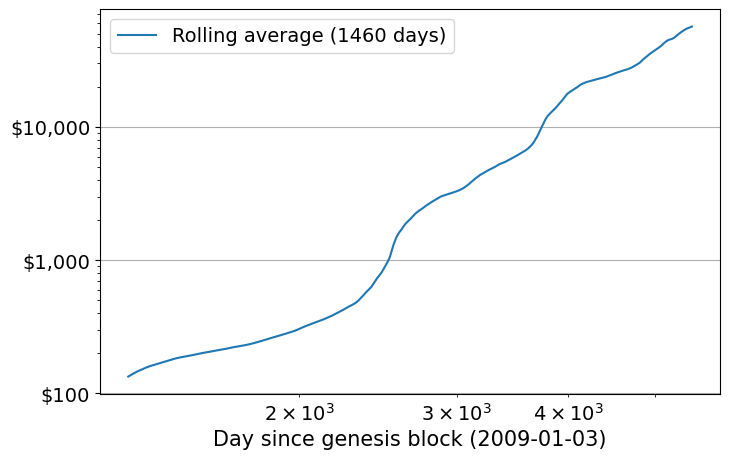

In [2]:
m2_growth_rate = 0.07 # average proportional increase of USD M2 supply per year
add_recent_price = True # adds more recent prices with API (requires yfinance, and curl_cffi recommended)

# Import price of BTC
btc_price = import_btc_price(hist_price_file='bitcoin_2009-08-26_2024-09-25.csv',  add_recent_price=add_recent_price)
btc_price.dropna(axis=1, inplace=True)
btc_halving_daygen, halving_mean_duration, peak_cycle_idx = find_halving_infos(btc_price)

# Adjust prices for USD devaluation, assuming constant rate, infinite velocity, etc
btc_price['Price_GEN'] = btc_price.apply(adjust_inflation_since_gen, args=[m2_growth_rate], axis=1)
display(btc_price.tail())

# Quick look at rolling averaged data
rolling_days = 4 * 365 # window of rolling average in days
btc_price_avg = plot_rolling_avg(btc_price, rolling_days)

# Fit PL support

The "support" of the price is fitted with a power-law: P = K * (t/t0)^a, where t0 is taken as the genesis block.

Using a quantile regressor removes the volatility (aka cycles), and finds the true support.

For better convergence, the fit is done with a linear model on log-log data (log(P) = log(K) + a * log(t/t0))

Quantile regression index = 5.26
Inliers only: index = 5.24


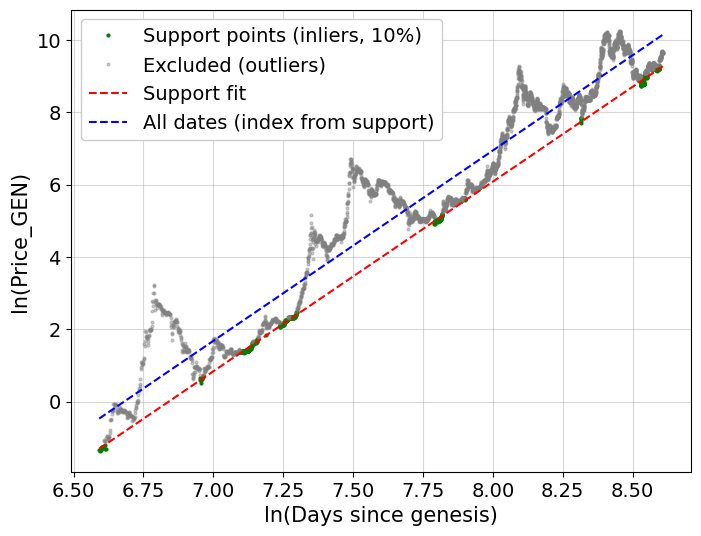

In [3]:
yaxis = 'Price_GEN' # either use M2-adjusted price ('Price_GEN', recommended), or real prices ('Price')
qr = .1 # fraction of data to keep for quantile fit of support (< 1)
date_fit_start, date_fit_end = '2011-01-01', '2024-01-01'

result_qr, result_support, result_all = fit_PL_loglog(btc_price, quantile=qr, date_fit_start=date_fit_start, date_fit_end=date_fit_end, yaxis=yaxis)
best_PL, support_PL = PL(result_all), PL(result_support)

The power-law index is near 5.24 (for M2 growth of 7%/year). Assuming Metcalfe's law, the corresponding node growth index is 2.6.

The result can be extrapolated and plotted in semi-log space for clarity.

The "best result" is a fit of the whole data set, using the fixed power-law exponent of the support.

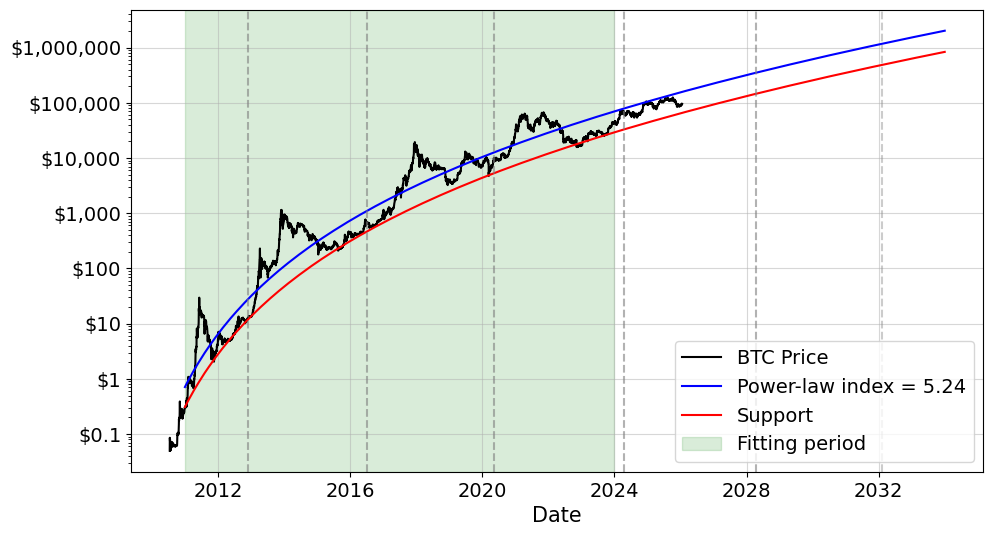

In [4]:
day_extra = 10 * 365 # number of days to extrapolate model
loglogplot = 0
df_best, df_support, btc_all_halving = extrapolate_PL(yaxis, best_PL, support_PL, btc_price, day_extra, date_fit_start, date_fit_end,
                                                      m2_growth_rate, btc_halving_daygen, halving_mean_duration, loglogplot)

# Fit cycles (Bull-Run)

To fit the cycles, or "bull-runs", more work is required. We assume that they are induced by the BTC halving, happening every 4 years approximately.

The price during cycles is normalized by the PL support (S): r = P/S - 1 

The shape is erratic, and chosen empirically as a Lorentzian function. The change in BTC creation decrease geometrically (by half), so the amplitude decreases geometrically as well.

name,value,standard error,relative error,initial value,min,max,vary
A0,4992.24640,103.608824,(2.08%),10.0,0.00000000,inf,True
mu,0.55012677,0.00957875,(1.74%),0.5,0.00000000,inf,True
sigma_c,137.661991,3.31448247,(2.41%),300.0,0.00000000,inf,True
d,441.124403,1.81291541,(0.41%),300.0,0.00000000,inf,True
PL_offset,0.31243583,0.05086561,(16.28%),0.0,-inf,inf,True


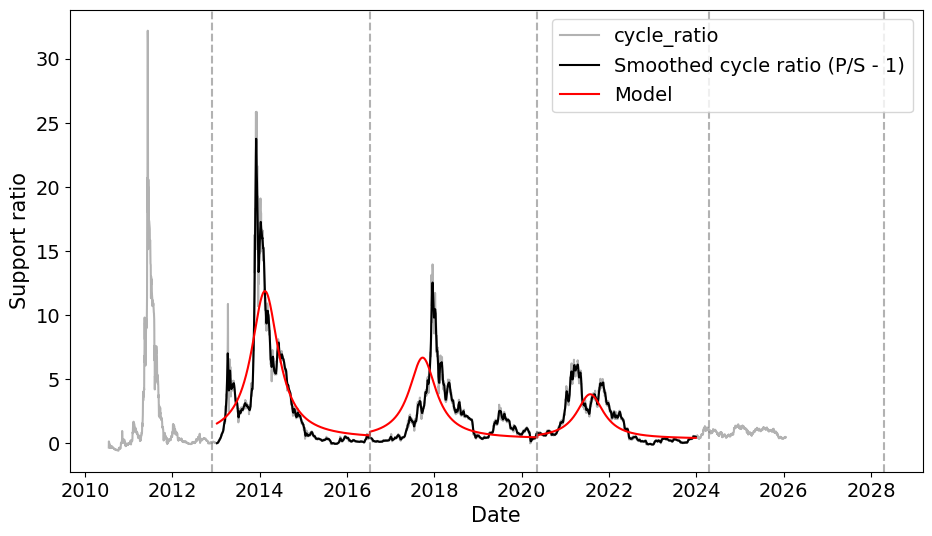

In [5]:
start_cycle_fit, end_cycle_fit = '2013-01-01', '2024-01-01' # remove first cycle
rolling_days = 10 # window of rolling average in days

btc_price.dropna(axis=1, inplace=True)
result_cycle = fit_cycle(btc_price, yaxis, support_PL, btc_halving_daygen, start_cycle_fit, end_cycle_fit, rolling_days)
result_cycle.params

The geometric ratio 'mu' is 0.55, close to 1/2. This confirms the hypothesis that the amplitudes of bull-run are linked with supply shock induced by halvings!

Now add back inflation and extrapolate:

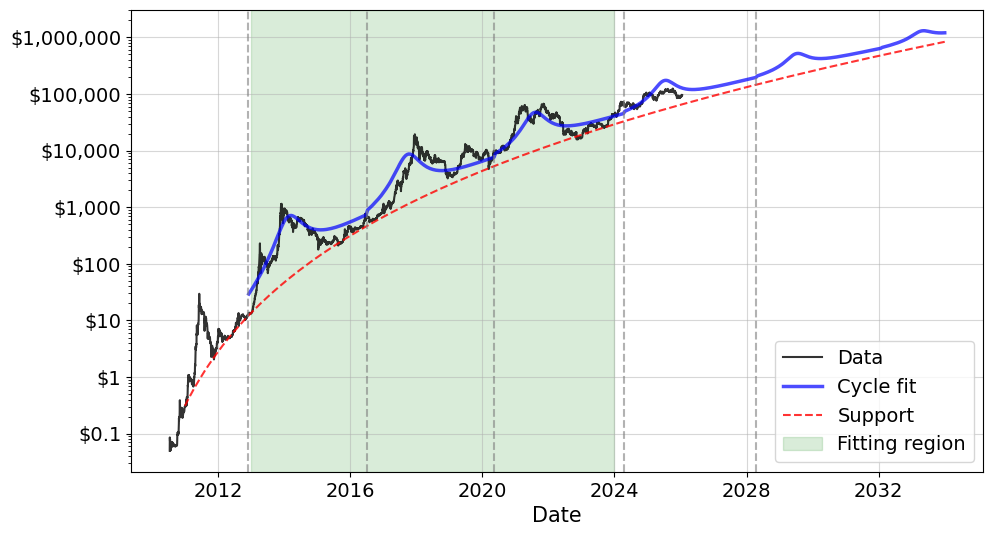

In [6]:
# uncomment to have interactive plotting (requires PyQt5)
# %matplotlib qt

df_best = extrapolate_cycle(yaxis, result_cycle, support_PL, btc_price, df_best, df_support,
                            start_cycle_fit, end_cycle_fit, btc_all_halving, m2_growth_rate)
plt.show()

The price is predicted over 3 orders of magnitude, with only 7 free parameters (2 for power-law, 5 for cycles ratio)

Unfortunately, the model is still imperfect and misses smaller "bull-runs". Most likely due to the inconsistency of M2, unexpected world events, etc.


In [7]:
find_support_current_price(btc_price, support_PL)

Current price of $ 95321 is the support of 2027-04-20, in 457 days 00:00:00
